# Hello, KAN!

### Kolmogorov-Arnold representation theorem

Kolmogorov-Arnold representation theorem states that if $f$ is a multivariate continuous function
on a bounded domain, then it can be written as a finite composition of continuous functions of a
single variable and the binary operation of addition. More specifically, for a smooth $f : [0,1]^n \to \mathbb{R}$,


$$f(x) = f(x_1,...,x_n)=\sum_{q=1}^{2n+1}\Phi_q(\sum_{p=1}^n \phi_{q,p}(x_p))$$

where $\phi_{q,p}:[0,1]\to\mathbb{R}$ and $\Phi_q:\mathbb{R}\to\mathbb{R}$. In a sense, they showed that the only true multivariate function is addition, since every other function can be written using univariate functions and sum. However, this 2-Layer width-$(2n+1)$ Kolmogorov-Arnold representation may not be smooth due to its limited expressive power. We augment its expressive power by generalizing it to arbitrary depths and widths.

### Kolmogorov-Arnold Network (KAN)

The Kolmogorov-Arnold representation can be written in matrix form

$$f(x)={\bf \Phi}_{\rm out}\circ{\bf \Phi}_{\rm in}\circ {\bf x}$$

where 

$${\bf \Phi}_{\rm in}= \begin{pmatrix} \phi_{1,1}(\cdot) & \cdots & \phi_{1,n}(\cdot) \\ \vdots & & \vdots \\ \phi_{2n+1,1}(\cdot) & \cdots & \phi_{2n+1,n}(\cdot) \end{pmatrix},\quad {\bf \Phi}_{\rm out}=\begin{pmatrix} \Phi_1(\cdot) & \cdots & \Phi_{2n+1}(\cdot)\end{pmatrix}$$

We notice that both ${\bf \Phi}_{\rm in}$ and ${\bf \Phi}_{\rm out}$ are special cases of the following function matrix ${\bf \Phi}$ (with $n_{\rm in}$ inputs, and $n_{\rm out}$ outputs), we call a Kolmogorov-Arnold layer:

$${\bf \Phi}= \begin{pmatrix} \phi_{1,1}(\cdot) & \cdots & \phi_{1,n_{\rm in}}(\cdot) \\ \vdots & & \vdots \\ \phi_{n_{\rm out},1}(\cdot) & \cdots & \phi_{n_{\rm out},n_{\rm in}}(\cdot) \end{pmatrix}$$

${\bf \Phi}_{\rm in}$ corresponds to $n_{\rm in}=n, n_{\rm out}=2n+1$, and ${\bf \Phi}_{\rm out}$ corresponds to $n_{\rm in}=2n+1, n_{\rm out}=1$.

After defining the layer, we can construct a Kolmogorov-Arnold network simply by stacking layers! Let's say we have $L$ layers, with the $l^{\rm th}$ layer ${\bf \Phi}_l$ have shape $(n_{l+1}, n_{l})$. Then the whole network is

$${\rm KAN}({\bf x})={\bf \Phi}_{L-1}\circ\cdots \circ{\bf \Phi}_1\circ{\bf \Phi}_0\circ {\bf x}$$

In constrast, a Multi-Layer Perceptron is interleaved by linear layers ${\bf W}_l$ and nonlinearities $\sigma$:

$${\rm MLP}({\bf x})={\bf W}_{L-1}\circ\sigma\circ\cdots\circ {\bf W}_1\circ\sigma\circ {\bf W}_0\circ {\bf x}$$

A KAN can be easily visualized. (1) A KAN is simply stack of KAN layers. (2) Each KAN layer can be visualized as a fully-connected layer, with a 1D function placed on each edge. Let's see an example below.

### Get started with KANs

Initialize KAN

In [41]:
from kan import *
torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[2,5,5], grid=3, k=3, seed=42, device=device)

cpu
checkpoint directory created: ./model
saving model version 0.0


Create dataset

In [42]:
from kan.utils import create_dataset
# create dataset f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.cos(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device=device, seed=0)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

Plot KAN at initialization

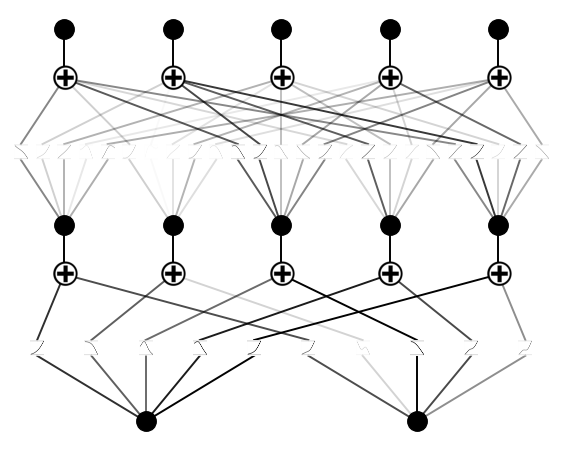

In [43]:
# plot KAN at initialization
model(dataset['train_input']);
model.plot(scale=0.7)

Train KAN with sparsity regularization

In [44]:
# train the model
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001);

| train_loss: 1.54e-02 | test_loss: 1.53e-02 | reg: 2.05e+01 | : 100%|█| 50/50 [00:08<00:00,  5.87it

saving model version 0.1


Plot trained KAN

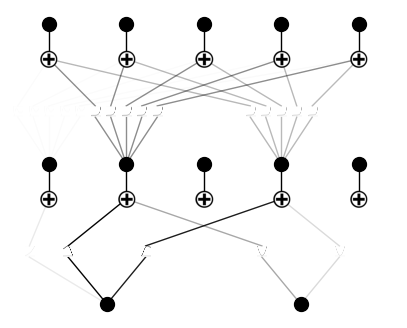

In [45]:
model.plot()

Prune KAN and replot

saving model version 0.6


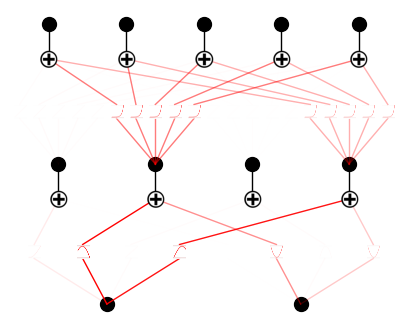

In [51]:
model = model.prune()
model.plot()

Continue training and replot

In [52]:
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 2.47e-01 | test_loss: 2.49e-01 | reg: 0.00e+00 | : 100%|█| 50/50 [00:09<00:00,  5.54it

saving model version 0.7


In [53]:
model = model.refine(10)

saving model version 0.8


In [54]:
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 1.66e-01 | test_loss: 1.63e-01 | reg: 0.00e+00 | : 100%|█| 50/50 [00:09<00:00,  5.35it

saving model version 0.9


Automatically or manually set activation functions to be symbolic

In [55]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

skipping (0,0,0) since already symbolic
skipping (0,0,1) since already symbolic
skipping (0,0,2) since already symbolic
skipping (0,0,3) since already symbolic
skipping (0,1,0) since already symbolic
skipping (0,1,1) since already symbolic
skipping (0,1,2) since already symbolic
skipping (0,1,3) since already symbolic
skipping (1,0,0) since already symbolic
skipping (1,0,1) since already symbolic
skipping (1,0,2) since already symbolic
skipping (1,0,3) since already symbolic
skipping (1,0,4) since already symbolic
skipping (1,1,0) since already symbolic
skipping (1,1,1) since already symbolic
skipping (1,1,2) since already symbolic
skipping (1,1,3) since already symbolic
skipping (1,1,4) since already symbolic
skipping (1,2,0) since already symbolic
skipping (1,2,1) since already symbolic
skipping (1,2,2) since already symbolic
skipping (1,2,3) since already symbolic
skipping (1,2,4) since already symbolic
skipping (1,3,0) since already symbolic
skipping (1,3,1) since already symbolic


Continue training till machine precision

In [56]:
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 1.00e-01 | test_loss: 1.00e-01 | reg: 0.00e+00 | : 100%|█| 50/50 [00:09<00:00,  5.43it

saving model version 0.11


Obtain the symbolic formula

In [57]:
from kan.utils import ex_round

ex_round(model.symbolic_formula()[0][0],4)

-0.2208*x_1 + 0.3895*x_2**2 + 0.0029*exp(0.972*(0.0002 - x_2)**2 + 6.4421*sin(1.333*x_1 - 4.8742)) + 0.9451*exp(-7.1814*(-x_1 - 0.2201)**2 + 1.0563*(-x_2 - 0.e-4)**2) + 0.2539*sin(0.9374*x_1 - 0.8296) + 0.4237